In [64]:
import pandas as pd
import tarfile
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [65]:
rows = []
with tarfile.open('results-pywren.tar') as tf:
    print(tf.getnames())
    for name in filter(lambda name: name.endswith('.json'), tf.getnames()):
        print(name)
        fp = tf.extractfile(name)
        if fp is not None:
            content = fp.read().decode('utf-8')
            row = json.loads(content)
            row['name'] = name
            rows.append(row)

['results', 'results/run-2-pywren-5000mb-cold.json', 'results/run-4-pywren-3000mb-warm.json', 'results/run-3-pywren-5000mb-cold.txt', 'results/run-2-pywren-10000mb-cold.json', 'results/run-3-pywren-5000mb-warm.json', 'results/run-5-pywren-3000mb-cold.json', 'results/run-4-pywren-3000mb-warm.txt', 'results/run-4-pywren-10000mb-cold.txt', 'results/run-3-pywren-10000mb-cold.json', 'results/run-5-pywren-10000mb-warm.json', 'results/run-1-pywren-5000mb-warm.txt', 'results/run-3-pywren-3000mb-cold.json', 'results/run-2-pywren-5000mb-warm.json', 'results/run-5-pywren-5000mb-warm.txt', 'results/run-5-pywren-10000mb-cold.json', 'results/run-5-pywren-3000mb-warm.txt', 'results/run-3-pywren-5000mb-cold.json', 'results/run-3-pywren-10000mb-warm.json', 'results/run-1-pywren-3000mb-cold.json', 'results/run-4-pywren-10000mb-warm.json', 'results/run-3-pywren-3000mb-warm.txt', 'results/run-3-pywren-3000mb-cold.txt', 'results/run-1-pywren-10000mb-cold.json', 'results/run-4-pywren-10000mb-warm.txt', 'res

In [66]:
df = pd.DataFrame(rows)
df['run'] = df['name'].apply(lambda name: int(name.split('-')[1]))
df['size'] = df['name'].apply(lambda name: int(name.split('-')[3].replace('mb', '')))
df['type']= df['name'].apply(lambda name: name.split('-')[4].split('.')[0])

In [82]:
df.iloc[0]['results']

[{'type': 'tuple',
  'framework': 'pywren',
  'input_files': ['s3://tuplex-public/data/100GB/zillow_00001.csv'],
  'load_time': 6.265846252441406,
  'run_time': 2.381929397583008,
  'write_time': 0.2686581611633301,
  'job_time': 8.916433811187744,
  'num_input_rows': 1218603,
  'num_output_rows': 21451},
 {'type': 'tuple',
  'framework': 'pywren',
  'input_files': ['s3://tuplex-public/data/100GB/zillow_00002.csv'],
  'load_time': 5.6295294761657715,
  'run_time': 2.301042318344116,
  'write_time': 0.18185758590698242,
  'job_time': 8.11242938041687,
  'num_input_rows': 1218603,
  'num_output_rows': 21451},
 {'type': 'tuple',
  'framework': 'pywren',
  'input_files': ['s3://tuplex-public/data/100GB/zillow_00003.csv'],
  'load_time': 6.275710582733154,
  'run_time': 2.3891007900238037,
  'write_time': 0.1821889877319336,
  'job_time': 8.847000360488892,
  'num_input_rows': 1218603,
  'num_output_rows': 21451},
 {'type': 'tuple',
  'framework': 'pywren',
  'input_files': ['s3://tuplex-pu

In [68]:
df.groupby(['size', 'type']).mean()

job_time  thereof_list_time  init_time  num_input_rows  \
size  type                                                            
3000  cold  31.793724           0.519142   0.026771     487441200.0   
      warm  21.421059           0.403278   0.019612     487441200.0   
5000  cold  32.950455           0.421284   0.022601     487441200.0   
      warm  30.007771           0.397351   0.019846     487441200.0   
10000 cold  32.729274           0.410716   0.022443     487441200.0   
      warm  25.152395           0.413808   0.019552     487441200.0   

            num_output_rows  num_input_files  run  
size  type                                         
3000  cold        8580400.0            400.0  3.0  
      warm        8580400.0            400.0  3.0  
5000  cold        8580400.0            400.0  3.0  
      warm        8580400.0            400.0  3.0  
10000 cold        8580400.0            400.0  3.0  
      warm        8580400.0            400.0  3.0

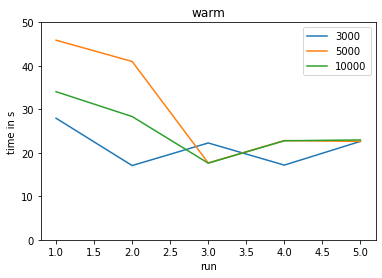

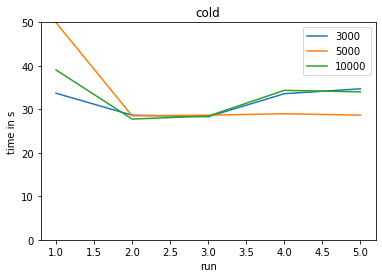

In [79]:
def plot_df(df, exp_type='warm'): 
    plt.figure()
    plt.title(exp_type)
    for group_name, group in df[df['type'] == exp_type].groupby('size'):

        #plt.plot(label=group_name)
        #print(group_name)
        group = group.sort_values('run')
        plt.plot(group['run'], group['job_time'], label=group_name)
    plt.legend()
    plt.xlabel('run')
    plt.ylabel('time in s')

    plt.ylim(0, 50)
plot_df(df, 'warm')
plot_df(df, 'cold')

In [80]:
df[df['type'] == 'cold'].groupby('size').mean()

,job_time,thereof_list_time,init_time,num_input_rows,num_output_rows,num_input_files,run
size,,,,,,,
3000,31.793724,0.519142,0.026771,487441200.0,8580400.0,400.0,3.0
5000,32.950455,0.421284,0.022601,487441200.0,8580400.0,400.0,3.0
10000,32.729274,0.410716,0.022443,487441200.0,8580400.0,400.0,3.0
